In [4]:
using Plots
using StatsBase
include("chebyshev_Q.jl")

Main.chebyshev_Q

# Test Q_discrete


In [1043]:
Q = chebyshev_Q.init_Q_discrete([0.0],[1.0],6,2,["nothing", "anything"],true )

Main.chebyshev_Q.Q_discrete([1, 2], ["nothing", "anything"], [0.0], [1.0], Any[Main.chebyshev_Q.OLS_chebyshev.polynomial(1, [0.0], [1.0], 6, Any[0, 1, 2, 3, 4, 5, 6], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], true), Main.chebyshev_Q.OLS_chebyshev.polynomial(1, [0.0], [1.0], 6, Any[0, 1, 2, 3, 4, 5, 6], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], true)], Main.chebyshev_Q.evaluate_Q_discrete, Main.chebyshev_Q.argmax_A_discrete, Main.chebyshev_Q.max_A_discrete)

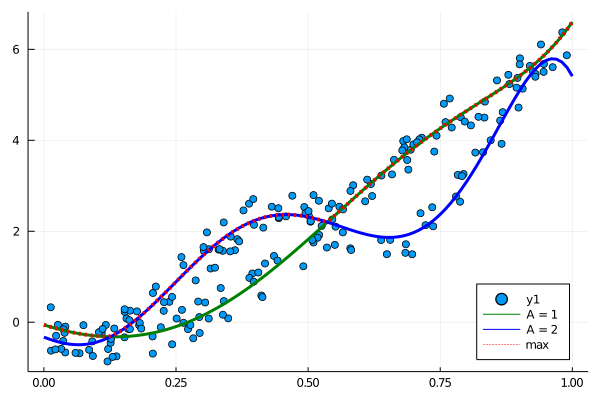

In [1044]:
N = 200
a = StatsBase.sample([1,2],N)
s = rand(N)

# simualted data
g(s,a) = sin(5*(a*s-0.5)).+5 .*s^2
Q_ = g.(s,a).+ rand(N) 
Plots.scatter(s,Q_)

chebyshev_Q.update_Q_discrete!(Q,a,s,Q_)

x = 0:0.01:1
y1 = broadcast(x -> chebyshev_Q.evaluate_Q_discrete(Q,[x],1)[1], x)
y2 = broadcast(x -> chebyshev_Q.evaluate_Q_discrete(Q,[x],2)[1], x)
y_max = broadcast(x -> Q.max_(Q,[x])[1],x)
Plots.plot!(x,y1, width = 3, color = "green", label = "A = 1")
Plots.plot!(x,y2, width = 3, color = "blue", label = "A = 2")
Plots.plot!(x,y_max, width = 4, color = "red", linestyle = :dot, legend =:bottomright, label = "max")


In [1046]:
Q = chebyshev_Q.init_Q_discrete([0.0,0.0],[1.0,1.0],6,2,[-2, 1],true )
N = 500
s =  broadcast(x -> rand(Distributions.Uniform(0,1),2), 1:N)
a = StatsBase.sample(1:2, N)

function g(s,a)
    return sin(a*5*x[1] .* x[2])
end 

Q_ = broadcast(i -> g(s[1],a[1]),1:N).+ 0.1.*(rand(N).-0.5)

chebyshev_Q.update_Q_discrete!(Q,a,s,Q_)



x = 0:0.01:1
xy = collect(Iterators.product(x,x))
v_true = g.(reshape(xy,length(xy)))
p1 = Plots.heatmap(reshape(v_true, length(x), length(x)))
v_fit = OLS_chebyshev.evaluate_polynomial(reshape(xy,length(xy)),poly)
p2 = Plots.heatmap(reshape(v_fit, length(x), length(x)))
p3 = Plots.heatmap(reshape(v_true .- v_fit, length(x), length(x)))
plot(p1,p2,p3,layout = 3)

LoadError: [91mtype Nothing has no field a[39m

# Test Q_continuous 

In [1041]:
s_ = [[1,1],[2,2],[0,1],[-1,0]]
s = s_[1]
for i in 2:length(s_) s = hcat(s,s_[i]) end
transpose(s)

4×2 LinearAlgebra.Transpose{Int64,Array{Int64,2}}:
  1  1
  2  2
  0  1
 -1  0

# Test Q_mixed

In [1036]:
s_[1]

2-element Array{Int64,1}:
 1
 1

# Q_data 

In [31]:
include("Q_data.jl")
using Distributions

In [32]:
q_data = Q_data.init_Q_data(100, 0.9, 2, 1)

Main.Q_data.data(1020, 0, [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]  …  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]  …  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

870 

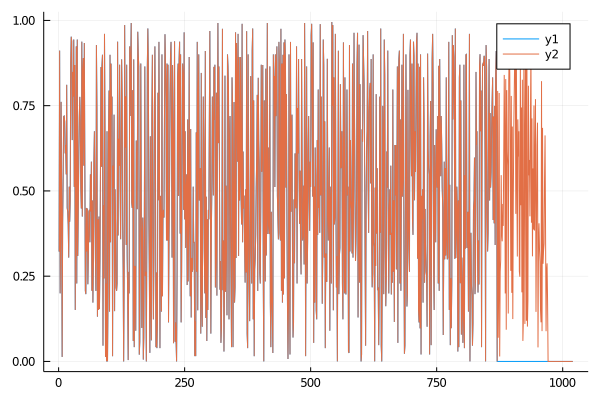

In [67]:
include("utils.jl")
N_samples = 100
s =broadcast(x -> rand(1), 1:N_samples)
a = broadcast(x -> StatsBase.sample(1:2, 1), 1:N_samples)
Q_ = rand(Distributions.Uniform(0,1), N_samples)
Q_data.sample_data!(q_data, 0.9)
Plots.plot(utils.reshape(q_data.s))
Q_data.add_data!(q_data, Q_, s, a)
Plots.plot!(utils.reshape(q_data.s))
#print(sum(q_data.a .== 0))


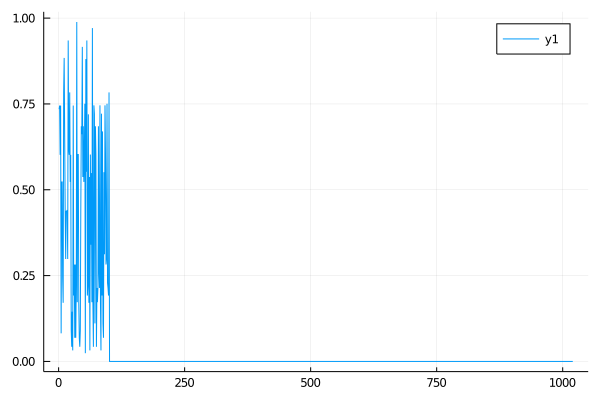

In [13]:
Plots.plot(utils.reshape(q_data.s))

# Test forward_bellman

In [864]:
include("../POMP/particle_filter.jl")
include("aprox_POMDP.jl")
include("../examples/linear_quadratic.jl")
include("chebyshev_Q.jl")
include("Q_data.jl")

using PlotThemes
theme(:dark)

function T!(x,c)
    return linear_quadratic.T!(x,c,linear_quadratic.pars1d)[1], -x[1]^2 - 4*abs(c)
end
function G(x,y,c)
    return linear_quadratic.G(x,y,c,linear_quadratic.pars1d)
end
function simulate_y(x,a)
    return linear_quadratic.simulate_y(x,linear_quadratic.pars1d)[1]
end


# togle N to see resutls for differnt levels of precision 
N = 200
x0, P0 = [0], [0.5]
prior = Distributions.MvNormal(x0, P0)
samples = rand(prior,N)

samples_ = [samples[:,1]]
for i in 2:N 
    push!(samples_, samples[:,i])
    #samples_ = vcat(samples_, [samples[:,i]]) 
end 
samples = samples_

weights = repeat([log(1.0/N)],N)
POMP_ = particle_filter.POMP(samples,weights,N,G,simulate_y,T!)


function stat(POMP)
    samples, weights = POMP.samples, POMP.weights
    mu = sum(broadcast(i->samples[i][1]*exp(weights[i]), 1:POMP.N))
    sigma = sqrt(sum(broadcast(i-> exp(weights[i])*(samples[i][1] -mu)^2, 1:POMP.N)))
    return [mu,sigma]
end 

function init_x(POMP)
    return particle_filter.sample_x(POMP,1)
end 



data = Q_data.init_Q_data(10000, 0.95, 1, 1)
Q_ = chebyshev_Q.init_Q_discrete([-10,0],[10,5],4,3,collect(-2:2:2),true)
print(" ")
POMDP_ = aprox_POMDP.POMDP(POMP_, particle_filter.simulated_joint_dynamics,stat,
                            particle_filter.init_samples!,
                            init_x,data, Q_, 0.95)

print(" ")

1  2  3  4  5  6  7  8  9  10  

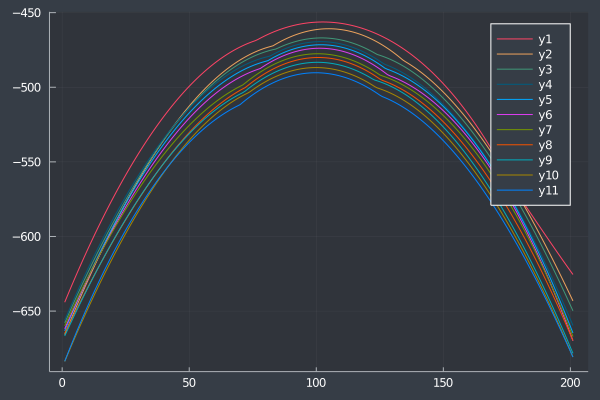

In [868]:

values = zeros(201,30)
mu = -10.0:0.1:10
sigma = 0.1:0.1:3
for i in 1:201
    for j in 1:30
        values[i,j] = POMDP_.Q.max_(POMDP_.Q,[mu[i],sigma[j]])[1]
    end
end
p1 = Plots.plot(values[:,15])

for i in 1:10
    print(i)
    print("  ")
    aprox_POMDP.step!(POMDP_, 2000, 0.5, 250, 2, 5)
    values = zeros(201,30)
    mu = -10.0:0.1:10
    sigma = 0.1:0.1:3
    for i in 1:201
        for j in 1:30
            values[i,j] = POMDP_.Q.max_(POMDP_.Q,[mu[i],sigma[j]])[1]
        end
    end
    Plots.plot!(p1,values[:,15])

end 
p1

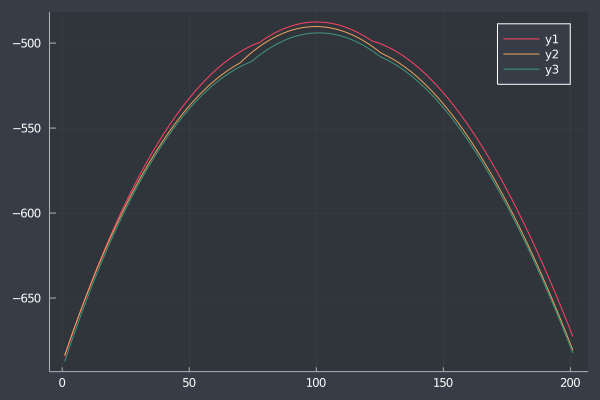

In [869]:
values = zeros(201,30)
mu = -10.0:0.1:10
sigma = 0.1:0.1:3
for i in 1:201
    for j in 1:30
        values[i,j] = POMDP_.Q.max_(POMDP_.Q,[mu[i],sigma[j]])[1]
    end
end
Plots.plot(values[:,1])
Plots.plot!(values[:,15])
Plots.plot!(values[:,30])

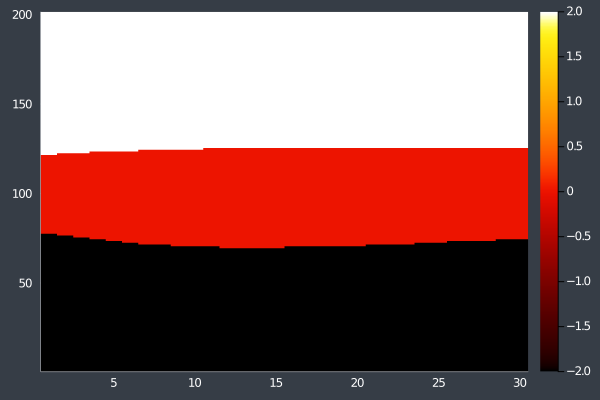

In [870]:
actions = zeros(201,30)
mu = -10.0:0.1:10
sigma = 0.1:0.1:3
for i in 1:201
    for j in 1:30
        \
        actions[i,j] = POMDP_.Q.argmax_(POMDP_.Q,[mu[i],sigma[j]])[1]
    end
end
Plots.heatmap(actions)


In [871]:
POMP_.samples

250-element Array{Float64,1}:
 -1.791963801197295
 -0.2835628888777488
 -0.22750636878716335
  0.9014697407591041
 -0.958215838996268
 -0.08371115032301107
 -0.6450288128648953
 -1.3913079571903844
  0.24810368544100495
 -1.0415581103812914
 -0.23042078687485984
  1.365604368867063
 -0.08371115032301107
  ⋮
  0.11886271420496664
 -2.22136366746124
  0.11886271420496664
 -1.5630315401730301
 -2.463327685027214
 -0.41680504408003327
  1.1075838174835901
 -0.8784543079291917
  1.057124492389889
 -1.9859271608523268
 -2.1494349888710977
 -2.1185610737918203

# Testing way to reshape and unpack broadcast fucntion output.

In [853]:
function T(x)
    for i in 1:10
        x  = 0.1*x + rand() - 0.5
    end 
    return [x,x], x
end 


T (generic function with 1 method)

In [854]:
function f1(x)
    for i in 1:100
        out = broadcast(T, 1:1000)
        s = broadcast(i->out[i][1], 1:1000)
        R = broadcast(i->out[i][2], 1:1000)
    end 
    return s, R
end

function f2(x)
    for i in 1:100
        s = broadcast(x -> T(x)[1], 1:1000)
        R = broadcast(x -> T(x)[2], 1:1000)
    end 
    return s, R
end



f2 (generic function with 1 method)

In [859]:
@time f1(1)

  0.012469 seconds (100.30 k allocations: 12.244 MiB)


([[2, 2], [4, 4], [6, 6], [8, 8], [10, 10], [12, 12], [14, 14], [16, 16], [18, 18], [20, 20]  …  [1982, 1982], [1984, 1984], [1986, 1986], [1988, 1988], [1990, 1990], [1992, 1992], [1994, 1994], [1996, 1996], [1998, 1998], [2000, 2000]], [2, 4, 6, 8, 10, 12, 14, 16, 18, 20  …  1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000])

In [860]:
@time f2(2)

  0.024216 seconds (200.20 k allocations: 19.861 MiB)


([[2, 2], [4, 4], [6, 6], [8, 8], [10, 10], [12, 12], [14, 14], [16, 16], [18, 18], [20, 20]  …  [1982, 1982], [1984, 1984], [1986, 1986], [1988, 1988], [1990, 1990], [1992, 1992], [1994, 1994], [1996, 1996], [1998, 1998], [2000, 2000]], [2, 4, 6, 8, 10, 12, 14, 16, 18, 20  …  1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000])

([[2, 2], [4, 4], [6, 6], [8, 8], [10, 10], [12, 12], [14, 14], [16, 16], [18, 18], [20, 20]  …  [1982, 1982], [1984, 1984], [1986, 1986], [1988, 1988], [1990, 1990], [1992, 1992], [1994, 1994], [1996, 1996], [1998, 1998], [2000, 2000]], [2, 4, 6, 8, 10, 12, 14, 16, 18, 20  …  1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000])